# Constant volume gas thermometer


**Code:** #121-000

**File:** `apps/ideal_gas/gas_thermometer.ipynb`

**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Ikergym/MinervaLab/master?filepath=apps%2Fideal_gas%2Fgas_thermometer.ipynb)

-----------

The aim of this notebook is to show how the empirical temperature can be defined using a constant volume gas thermometer.

## Interface

The main interface (``main_block_121_000``) is divided in two VBox: ``left_block_121_000`` and ``center_block_121_000``.

``left_block_121_000`` contains the following widgets: ``T_slider``, ``gas_dropdown``, ``p_pt_slider``, ``Theta_text``, ``save_button``, ``clear_button`` and ``show_lines_check``.

``center_block_121_000`` contains the bqplot figure ``fig_121_001``.

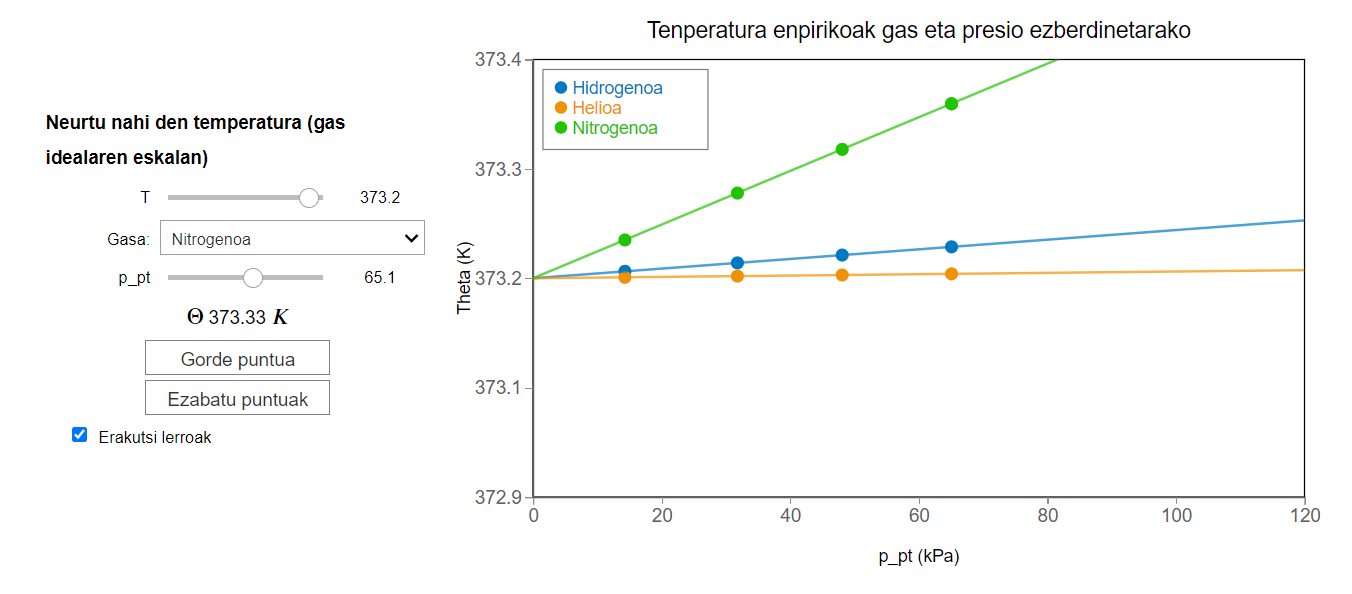

In [2]:
from IPython.display import Image
Image(filename='../../static/images/apps/ideal_gas/121-000.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [ ]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.widget-label { display: contents !important; }</style>"))
display(HTML("<style>.slider-container { margin: 12px !important; }</style>"))
display(HTML("<style>.jupyter-widgets { overflow: auto !important; }</style>"))

## Packages

In [ ]:
import numpy as np

from bqplot import *
import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

## Physical functions

This are the functions that have a physical meaning:

- `get_v`
- `get_theta`
- `get_theta_values`


In [ ]:
def get_v(p_pt, gas):
    '''
    This functions calculates the v value of a given gas
    for a given p_pt and T_pt by solving the Van der Waals Equation.
    T_pt is defined by convention as 273.16K.
    
    $p_{pt} v^3 -(RT_{pt}+p_{pt}) v^2 +av -ab = 0 $
    
    Inputs:
    p_pt: float value for the pressure of the gas, when it is in thermal equilibrium with the Triple Point of Water
    gas: integer index to characterize a gas
    
    Returns:
    v: float value for the volume of the gas corresponding to the given p_pt and T_pt
    '''
    
    a = a_data[gas]
    b = b_data[gas]
    poly = np.poly1d([p_pt, -R*T_pt -p_pt*b, a, -a*b])
    solutions = np.roots(poly) #This statement uses numpy roots to solve third order polynomial equation
    v = 0.0
    for sol in solutions: #This control statement selects the only real solution.
            if abs(sol.imag) < 1e-5:
                v = sol.real
    return v

In [ ]:
def get_Theta(p_pt,T,gas):
    '''
    This function calculates the $\Theta$ (empirical temperature) of a given gas
    for a given values of p and p_pt by applying the definition of empirical temperature.
    
    $\Theta = \lim_{p_{pt} \rightarrow 0} 273.16K \frac{p}{p_{pt}}ç$
    
    Inputs:
    p_pt: float value for the pressure of the gas, when it is in thermal equilibrium with the Triple Point of Water
    T: float value for the real temperature for which empirical temperature is being calculated
    gas: integer index to characterize a gas
    
    Returns:
    Theta:float value for the empirical temperature corresponding to gas i and pressures p_pt and p
    '''
    
    a = a_data[gas]
    b = b_data[gas]
    v = get_v(p_pt,gas)
    if abs(v - 0.0) < 1e-5:
        Theta = T
    else:
        p = (R*T/(v-b)-a/v**2)
        Theta = (p/p_pt * 273.16)
    return Theta

In [ ]:
def get_Theta_values(p_pt_values,T):
    '''
    This function applies iteratively the get_Theta function
    to get a 2d numpy array of the Theta values for every gas and
    p_pt. This array is used as a mark to generate the lines
    
    Inputs:
    p_pt_values: 1d numpy array for the p_pt values for which we are calculating Theta
    T: float value for the real temperature for which empirical temperature is being calculated
    
    Returns
    Theta_values: 2d numpy array for the Theta values for each gas (first index) and each p_pt(second index)
    '''
    
    Theta_values = np.empty((3,n_of_points)) # This statement generates an empty 2d numpy array with correct dimensions.
    for gas in [0,1,2]:
        for i in range(n_of_points):
            Theta_values[gas,i] = get_Theta(p_pt_values[i],T,gas)
    return Theta_values
    

## Functions related with the interaction

In [ ]:
def update_current_point(change):
    '''
    This function is called  whenever the x,y or color values are changed
    (or when real temperature is changed). It updates the current_point mark
    (the one with the moving tracer). The changed values are x, y and color
    values of current_point mark and the Theta_text output (which gives the
    current y value on screen).
    '''
    
    gas = Gas_dropdown.value
    p_pt = p_pt_slider.value
    T = T_slider.value
    
    Theta = get_Theta(p_pt,T,gas)
    current_point.x = [p_pt]
    current_point.y = [Theta]
    current_point.colors = [colors[gas]]
    Theta_text.value = '%.2f' % Theta

In [ ]:
def save_point(change):
    '''
    This function is called whenever the save_button is clicked.
    It saves the current_point marks values in the corresponding mark
    depending on which gas is currently selected'''
    
    gas = Gas_dropdown.value
    if gas == 0:
        saved_points_0.x = np.append(saved_points_0.x, current_point.x )
        saved_points_0.y = np.append(saved_points_0.y, current_point.y )
    elif gas == 1:
        saved_points_1.x = np.append(saved_points_1.x, current_point.x)
        saved_points_1.y = np.append(saved_points_1.y, current_point.y)
    elif gas == 2:
        saved_points_2.x = np.append(saved_points_2.x, current_point.x)
        saved_points_2.y = np.append(saved_points_2.y, current_point.y)

In [ ]:
def show_lines(change):
    '''
    This function is called whenever the show_lines checkbox
    value changes. It shows/hides the lines mark depending on
    value of the checkbox.
    '''
    
    lines.visible = show_lines_check.value

In [ ]:
def clear(change):
    '''
    This function is called whenever the clear_button is clicked or when the real Temperature value
    is changed. It clears all the data on the marks saved_points_i. This removes all scatter points
    in the figure except the current_point (x,y) point.
    '''
    
    saved_points_0.x = []
    saved_points_0.y = []
    saved_points_1.x = []
    saved_points_1.y = []
    saved_points_2.x = []
    saved_points_2.y = []

In [ ]:
def update_temperature(change):
    '''
    This function is called whenever the real Temperature value (controlled with T_slider)
    is changed. It updates the Theta_values array for the new temperature and rescales the
    x_scale and y_scale to an appropiate scale for that temperature. It also clears all points
    in the figure except the current_point (x,y) point
    '''
    
    T = T_slider.value
    Theta_values = get_Theta_values(p_pt_values,T)
    
    clear(None)
    
    scale_y = bqs.LinearScale(min = T-0.2, max = T+0.2)
    axis_y.scale = scale_y    
    for mark in fig_121_001.marks:
        mark.scales = {'x': scale_x, 'y': scale_y}
        
    
    update_current_point(None)
    lines.y = Theta_values

## Main interface

In [ ]:
# Fixed Parameters:
R = 8.31446 # Gas constant in L*kPa/K/mol
T_pt = 273.16 # Temperature of fixed point (triple point of water) in K.

# Plot parameters:
p_min = 0.0
p_max = 120.0
T_min = 100.0
T_max = 400.0

# Gas data:
labels = ["Hidrogenoa","Helioa","Nitrogenoa"]#, "Oxigenoa", "Neona", "Argona"]
latex = ["$H_2$", "$He$", "$N_2$"]#, "$O_2$", "$Ne$", "$Ar$"]
a_data = [24.7100, 3.4600, 137.00]#, 138.2, 21.3500, 135.500]
b_data = [0.02661, 0.0238, 0.0387]#, 0.03186, 0.01709, 0.03201]
colors = ['#0079c4','#f09205','#21c400']#,'#dd4e4f', '#ae8ccd', '#86564b']
opacities = [0.7, 0.7, 0.7]

# Initial state:
gas=0
p_pt = 100.0
T = 373.16
Theta = get_Theta(p_pt,T,gas)

# Lines parameters
n_of_points = 2 # Integer parameter to control how many points are to be calculated for lines
p_pt_values= np.linspace(0.1,120.0,n_of_points)
Theta_values = get_Theta_values(p_pt_values,T)




#######################################
#######CREATE THE FIGURES##############
#######################################


fig_121_001 = bq.Figure(title='Tenperatura enpirikoak gas eta presio ezberdinetarako',
                marks=[],
                axes=[],
                padding_x=0.0,
                animation_duration=0,
                legend_location='top-left',
                legend_style= {'fill': 'white', 'stroke': 'grey'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=70, bottom=60, left=80, right=30),
                layout = widgets.Layout(width='100%'),
                toolbar = True,
    )

scale_x = bqs.LinearScale(min = p_min, max = p_max, allow_padding = False)
scale_y = bqs.LinearScale(min = T-0.2, max = T+0.2)

axis_x = bqa.Axis(scale=scale_x,
                tick_format='.0f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(p_min, p_max, 7),
                #num_ticks=7,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='p_pt (kPa)',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y = bqa.Axis(
                scale=scale_y,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                num_ticks=5,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='Theta (K)',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_121_001.axes = [axis_x,axis_y]





#######################################
#########CREATE THE MARKS##############
#######################################


x_values = [ p_pt_values for i in range(3)]
y_values = Theta_values


current_point = bqm.Scatter(
                x = [p_pt], 
                y = [Theta], 
                scales = {'x': scale_x, 'y': scale_y}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = [colors[gas]],
                labels = [labels[gas]],
                display_legend = False,
                tooltip = bq.Tooltip(fields=['x', 'y'], labels=['p_pt:', 'Theta:'], formats=['.2f', '.2f'])
)


saved_points_0 = bqm.Scatter(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = [colors[0]],
                labels = [labels[0]],
                display_legend = True
)

saved_points_1 = bqm.Scatter(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = [colors[1]],
                labels = [labels[1]],
                display_legend = True
)

saved_points_2 = bqm.Scatter(
                x = [], 
                y = [], 
                scales = {'x': scale_x, 'y': scale_y}, 
                opacities = [1.0],
                visible = True, #True, #t == '1.00',
                colors = [colors[2]],
                labels = [labels[2]],
                display_legend = True
)

lines = bqm.Lines(
                x = x_values, 
                y = y_values, 
                scales = {'x': scale_x, 'y': scale_y}, 
                opacities = opacities,
                visible = False, #True, #t == '1.00',
                colors = colors,
                labels = labels,
                display_legend = False
)

fig_121_001.marks = [current_point, saved_points_0, saved_points_1, saved_points_2, lines]





#######################################
#########CONTROL WIDGETS###############
#######################################

## Left Block (temperature, pressure and gas controls)

T_slider = widgets.FloatSlider(
    min=100.0,
    max=400.0,
    step=1.0,
    value=T,
    description='T',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

T_slider.observe(update_temperature,'value')



Gas_dropdown = widgets.Dropdown(
    options=[('Hidrogenoa',0), ('Helioa',1), ('Nitrogenoa',2)],
    value=0,
    description='Gasa:',
    disabled=False,
)

Gas_dropdown.observe(update_current_point, 'value') 


p_pt_slider = widgets.FloatSlider(
    min=p_min,
    max=p_max,
    step=0.1,
    value=100.0,
    description='p_pt',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

p_pt_slider.observe(update_current_point,'value')

Theta_text = widgets.Label(
    value = '%.2f' % Theta
)


save_button = widgets.Button(
    description='Gorde puntua',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me'
)

save_button.on_click(save_point)


clear_button = widgets.Button(
    description='Ezabatu puntuak',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me'
)

clear_button.on_click(clear)


show_lines_check = widgets.Checkbox(
    description='Erakutsi lerroak',
    disabled=False,
    value=False,
)

show_lines_check.observe(show_lines, 'value')

#######################################
############  LAYOUT  #################
#######################################



Temperature_Box = widgets.HBox([widgets.Label(value='$\Theta$'), Theta_text, widgets.Label(value='$K$')])

left_block_121_000 = widgets.VBox([], layout=widgets.Layout(width='30%', align_items='center'))
left_block_121_000.children = [widgets.HTML(value='<b>Neurtu nahi den temperatura (gas idealaren eskalan)</b>'),
                               T_slider, Gas_dropdown, p_pt_slider, Temperature_Box, save_button, clear_button, show_lines_check]


centre_block_121_000 = widgets.VBox([], layout=widgets.Layout(width='70%', align_items='center'))

centre_block_121_000.children = [fig_121_001]




main_block_121_000 = widgets.HBox([], layout=widgets.Layout(width='100%', align_self='center', align_items='center'))
main_block_121_000.children = [left_block_121_000, centre_block_121_000]

main_block_121_000